In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from joblib import Parallel, delayed
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
adata = sc.read_10x_mtx(
"datasets",
var_names="gene_symbols",
cache=True
)
adata.var_names_make_unique()
#Adding patient column to the adata:
meta = pd.read_csv("datasets/metadata.csv.gz")
type(meta)
meta.columns = ["cell_id", "tissue", "patient", "cell-type"]

patient_12_df = meta[meta["patient"] == "PA12"]
patient_12_pbmc = patient_12_df.loc[patient_12_df["tissue"] == "PBMC", "cell_id"].values.tolist()
#pbmc is control
# print(patient_12_pbmc)
patient_12_tumor = patient_12_df.loc[patient_12_df["tissue"] == "Tumor", "cell_id"].values.tolist()    
# print(patient_12_tumor)

patient_04_df = meta[meta["patient"] == "PA04"]
# print(patient_04_df["tissue"])
patient_04_adj_normal = patient_04_df.loc[patient_04_df["tissue"] == "Adjacent_normal", "cell_id"].values.tolist()
# print(patient_04_adj_normal)

patient_04_tumor = patient_04_df.loc[patient_04_df["tissue"] == "Tumor", "cell_id"].values.tolist() 
# print(patient_04_tumor)

adata.obs["patient"] = "ignore"
adata.obs.loc[patient_12_pbmc, "patient"] = "PA12_PBMC" #high NI, control 
adata.obs.loc[patient_12_tumor, "patient"] = "PA12_Tumor" #high NI, tumor
adata.obs.loc[patient_04_adj_normal, "patient"] = "PA04_AdjNormal" #low NI, control
adata.obs.loc[patient_04_tumor, "patient"] = "PA04_Tumor" #low NI, tumor

scanpy==1.10.3 anndata==0.10.8 umap==0.5.9.post2 numpy==1.23.5 scipy==1.13.1 pandas==2.3.2 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 louvain==0.8.2 pynndescent==0.5.13
... reading from cache file cache/datasets-matrix.h5ad


In [2]:
adata2 = adata[adata.obs["patient"].isin(["PA04_AdjNormal", "PA12_PBMC", "PA04_Tumor", "PA12_Tumor"])].copy()
adata2.obs

,patient
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,PA04_AdjNormal
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,PA04_AdjNormal
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,PA04_AdjNormal
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,PA04_AdjNormal
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,PA04_AdjNormal
...,...
PDAC12-Tumor-GEX_out_TTTGTCAGTGTCGCTG-1,PA12_Tumor
PDAC12-Tumor-GEX_out_TTTGTCATCATCGATG-1,PA12_Tumor
PDAC12-Tumor-GEX_out_TTTGTCATCCCTTGTG-1,PA12_Tumor
PDAC12-Tumor-GEX_out_TTTGTCATCTACCTGC-1,PA12_Tumor


In [3]:
#filter 20 highest expressed genes
#sc.pl.highest_expr_genes(adata, n_top=20, )
#filtering out the cells with low gene expression/genes that don't show up in many cells
adata3 = adata2.copy()
sc.pp.filter_cells(adata3, min_genes=200)
sc.pp.filter_genes(adata3, min_cells=3)
#annotate mitochondrial, ribosomal, and hemoglobin genes
adata3.var['mt'] = adata3.var_names.str.startswith('MT-')
adata3.var['ribo'] = adata3.var_names.str.startswith(("RPS", "RPL"))
adata3.var['hb'] = adata3.var_names.str.startswith("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata3, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

filtered out 5672 genes that are detected in less than 3 cells


In [4]:
adata4 = adata3[
(adata3.obs['pct_counts_mt'] < 10) &
(adata3.obs['pct_counts_ribo'] < 20) &
(adata3.obs['pct_counts_hb'] < 5),
:
].copy()

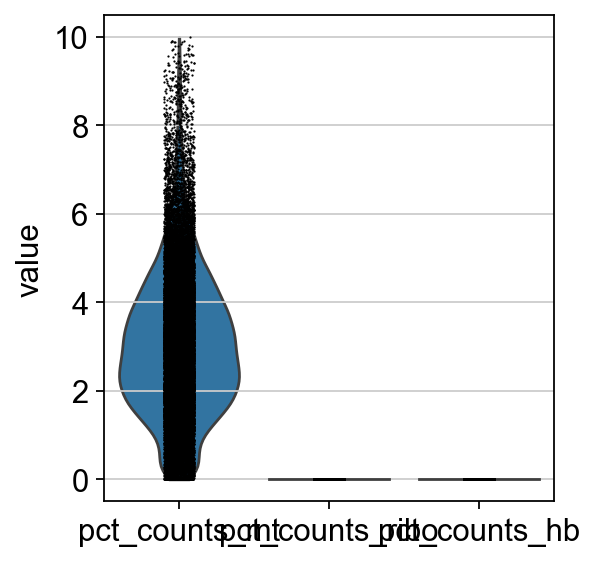

In [5]:
#PLOT
sc.pl.violin(adata4, ['pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'])

In [6]:
# Doublet detection and removal
adata5 = adata4.copy()
sc.pp.scrublet(adata5)

Running Scrublet
filtered out 139 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 33.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%
    Scrublet finished (0:02:57)


In [7]:
print(adata5.obs["predicted_doublet"])
adata6 = adata5[adata5.obs["predicted_doublet"] == False].copy()

PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1    False
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1    False
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1    False
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1    False
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1    False
                                            ...  
PDAC12-Tumor-GEX_out_TTTGTCAGTGTCGCTG-1     False
PDAC12-Tumor-GEX_out_TTTGTCATCATCGATG-1     False
PDAC12-Tumor-GEX_out_TTTGTCATCCCTTGTG-1     False
PDAC12-Tumor-GEX_out_TTTGTCATCTACCTGC-1     False
PDAC12-Tumor-GEX_out_TTTGTCATCTCGAGTA-1     False
Name: predicted_doublet, Length: 32263, dtype: bool


In [8]:
# Saving count data
adata6.layers["counts"] = adata6.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata6)
# Logarithmize the data
sc.pp.log1p(adata6)

normalizing counts per cell
    finished (0:00:00)


In [9]:
#separate the matrix into 4 separate files (PBMC and Tumor for both patients)

adata7 = adata6[adata6.obs["patient"].isin(["PA04_AdjNormal"])].copy()
adata7.write("datasets/PA04_AdjNormal.h5ad")

adata8 = adata6[adata6.obs["patient"].isin(["PA12_PBMC"])].copy()
adata8.write("datasets/PA12_PBMC.h5ad")

adata9 = adata6[adata6.obs["patient"].isin(["PA04_Tumor"])].copy()
adata9.write("datasets/PA04_Tumor.h5ad")

adata10 = adata6[adata6.obs["patient"].isin(["PA12_Tumor"])].copy()
adata10.write("datasets/PA12_Tumor.h5ad")

In [12]:
adata7.obs

,patient,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,doublet_score,predicted_doublet
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,PA04_AdjNormal,1404,1404,7.247793,2724.0,7.910223,29.405286,38.362702,49.118943,66.813510,...,4.584968,3.560940,0.0,0.0,0.0,0.0,0.0,0.0,0.030018,False
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,PA04_AdjNormal,4265,4265,8.358432,16713.0,9.724002,34.045354,43.020403,51.594567,63.232214,...,6.401917,3.601987,0.0,0.0,0.0,0.0,0.0,0.0,0.035706,False
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,PA04_AdjNormal,1621,1621,7.391415,3903.0,8.269757,36.100436,45.785293,55.649500,71.278504,...,4.962845,3.638227,0.0,0.0,0.0,0.0,0.0,0.0,0.024561,False
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,PA04_AdjNormal,1174,1174,7.069023,2438.0,7.799344,34.126333,44.134537,55.168171,72.354389,...,4.317488,3.035275,0.0,0.0,0.0,0.0,0.0,0.0,0.025276,False
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,PA04_AdjNormal,1346,1346,7.205635,3113.0,8.043663,38.997751,47.414070,57.115323,72.823643,...,3.951244,1.638291,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDAC04-Normal-GEX_out_TTTGTCATCGATCCCT-1,PA04_AdjNormal,1161,1161,7.057898,2197.0,7.695303,32.817478,42.239417,52.662722,69.913518,...,4.007333,2.457897,0.0,0.0,0.0,0.0,0.0,0.0,0.042654,False
PDAC04-Normal-GEX_out_TTTGTCATCGGCATCG-1,PA04_AdjNormal,1557,1557,7.351158,4046.0,8.305731,40.434998,49.728127,58.897677,73.875433,...,4.532599,2.273851,0.0,0.0,0.0,0.0,0.0,0.0,0.019193,False
PDAC04-Normal-GEX_out_TTTGTCATCTAACTTC-1,PA04_AdjNormal,1471,1471,7.294377,3433.0,8.141481,36.061754,45.674337,55.840373,71.715701,...,4.094345,1.718614,0.0,0.0,0.0,0.0,0.0,0.0,0.030453,False
PDAC04-Normal-GEX_out_TTTGTCATCTCAACTT-1,PA04_AdjNormal,1356,1356,7.213032,2836.0,7.950502,33.921016,42.806770,53.173484,69.816643,...,3.871201,1.657264,0.0,0.0,0.0,0.0,0.0,0.0,0.031341,False


In [11]:
adata7.obs

,patient,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,doublet_score,predicted_doublet
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,PA04_AdjNormal,1404,1404,7.247793,2724.0,7.910223,29.405286,38.362702,49.118943,66.813510,...,4.584968,3.560940,0.0,0.0,0.0,0.0,0.0,0.0,0.030018,False
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,PA04_AdjNormal,4265,4265,8.358432,16713.0,9.724002,34.045354,43.020403,51.594567,63.232214,...,6.401917,3.601987,0.0,0.0,0.0,0.0,0.0,0.0,0.035706,False
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,PA04_AdjNormal,1621,1621,7.391415,3903.0,8.269757,36.100436,45.785293,55.649500,71.278504,...,4.962845,3.638227,0.0,0.0,0.0,0.0,0.0,0.0,0.024561,False
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,PA04_AdjNormal,1174,1174,7.069023,2438.0,7.799344,34.126333,44.134537,55.168171,72.354389,...,4.317488,3.035275,0.0,0.0,0.0,0.0,0.0,0.0,0.025276,False
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,PA04_AdjNormal,1346,1346,7.205635,3113.0,8.043663,38.997751,47.414070,57.115323,72.823643,...,3.951244,1.638291,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDAC04-Normal-GEX_out_TTTGTCATCGATCCCT-1,PA04_AdjNormal,1161,1161,7.057898,2197.0,7.695303,32.817478,42.239417,52.662722,69.913518,...,4.007333,2.457897,0.0,0.0,0.0,0.0,0.0,0.0,0.042654,False
PDAC04-Normal-GEX_out_TTTGTCATCGGCATCG-1,PA04_AdjNormal,1557,1557,7.351158,4046.0,8.305731,40.434998,49.728127,58.897677,73.875433,...,4.532599,2.273851,0.0,0.0,0.0,0.0,0.0,0.0,0.019193,False
PDAC04-Normal-GEX_out_TTTGTCATCTAACTTC-1,PA04_AdjNormal,1471,1471,7.294377,3433.0,8.141481,36.061754,45.674337,55.840373,71.715701,...,4.094345,1.718614,0.0,0.0,0.0,0.0,0.0,0.0,0.030453,False
PDAC04-Normal-GEX_out_TTTGTCATCTCAACTT-1,PA04_AdjNormal,1356,1356,7.213032,2836.0,7.950502,33.921016,42.806770,53.173484,69.816643,...,3.871201,1.657264,0.0,0.0,0.0,0.0,0.0,0.0,0.031341,False
